In [1]:
from dask_yarn import YarnCluster
from dask.distributed import Client
import matplotlib.pyplot as plt
%matplotlib inline


/home/hadoop/miniconda/lib/python3.8/site-packages/dask_yarn/core.py:16: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import (
/home/hadoop/miniconda/lib/python3.8/site-packages/dask_yarn/core.py:16: FutureWarning: parse_timedelta is deprecated and will be removed in a future release. Please use dask.utils.parse_timedelta instead.
  from distributed.utils import (


In [2]:
# Create a cluster where each worker has 4 vCPU core and 8 GiB of memory:
cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
                      worker_vcores = 4,
                      worker_memory = "8GiB"
                      )

# Scale cluster out to 2 such workers:
cluster.scale(2)

# Connect to the cluster (before proceeding, you should wait for workers to be registered by the dask scheduler, as below):
client = Client(cluster)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://172.31.27.255:8786
distributed.scheduler - INFO -   dashboard at:                    :34745
distributed.scheduler - INFO - Receive client connection: Client-d4948bec-f98d-11ed-9367-0a06fa8a329b
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.30.131:35849', name: dask.worker_1, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.30.131:35849
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.22.22:36425', name: dask.worker_0, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.22.22:36425
distributed.core - INFO - Starting established connection


In [3]:
client


Connection method: Cluster object,Cluster type: YarnCluster
Dashboard: /proxy/34745/status,


In [4]:
import dask.dataframe as dd

df = dd.read_parquet("s3://amazon-reviews-pds/parquet/product_category=Electronics/*.parquet",
                     storage_options={'anon': True, 'use_ssl': False},
                     engine='fastparquet')

/home/hadoop/miniconda/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/hadoop/miniconda/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/hadoop/miniconda/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [5]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year
0,US,52826068,R3SC2T77Y0PSN8,B00FIYDC1W,822091995,Monster DNA Over-Ear Headphones,4,0,0,Y,N,"Very nice sound, comfortable",These headphones are very nice. Sound is quit...,2014-04-09,2014
1,US,13676500,R2ONIZ7ICKORQV,B00E19H9U0,662432872,Tech Armor 30ML Go Cleaning Kit with ExtraMove...,5,0,0,N,Y,Five Stars,Arrived as expected great product,2014-11-17,2014
2,US,9133162,R3RN22LN1VUJR6,B00ELCP55I,576075415,Mpow&reg; FreeGo Wireless Bluetooth 4.0 Headse...,4,3,4,N,Y,really enjoyed this product,the reason I chose this product because of de...,2014-04-09,2014
3,US,15154971,R36LBJWIVBO9M8,B00A6Q596I,533568175,1080P 30 Pin Dock Male to HDMI Male Adapter Ca...,4,0,0,N,N,Works on Ipad 2?,Works on Ipad 2?,2014-11-17,2014
4,US,12151874,RW983892SG9VP,B000HKGK8Y,544321119,"RCA ANT111Z Durable FM Antenna, Rabbit Ears",5,0,0,N,Y,Works great!,I am very happy with this antenna. Works like ...,2014-04-09,2014


## Plot 1: What is the distribution of the no. of reviews across time?

<Axes: title={'center': 'Number of reviews across years'}, xlabel='year', ylabel='No. of reviews'>

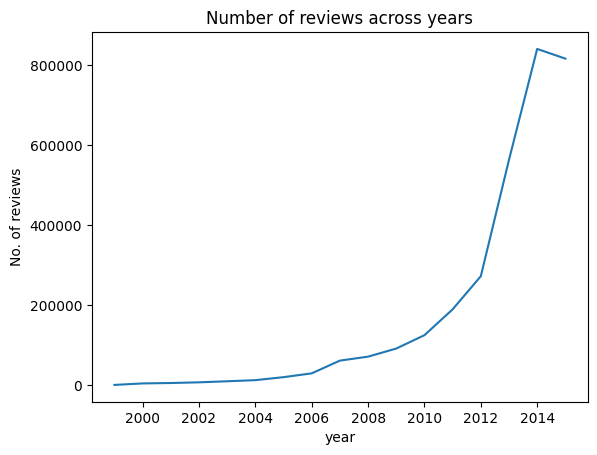

In [7]:
reviews_by_year = (df[['year','vine']].groupby('year').count())
reviews_df = reviews_by_year.compute()
# x = [2000, 2005, 2010, 2015]
reviews_df.plot(kind="line", title= "Number of reviews across years",
           ylabel = "No. of reviews",legend=None)

### Description 1:

Plot 1 clearly depicts a notable surge in the number of reviews from 1998 to 2015. This could be attributed to the growing population of Internet users and the widespread popularity of electronics. Consequently, the plot prompts the question of whether there exists a correlation between the number of reviews and the star rating. 

## Plot 2: What is the average star rating across time?

In [8]:
# Average star rating across years 
score_year = (df[['year', 'star_rating']].groupby('year').mean())
scores = score_year.compute()


<Axes: title={'center': 'Average star rating across years'}, xlabel='year', ylabel='Average rating'>

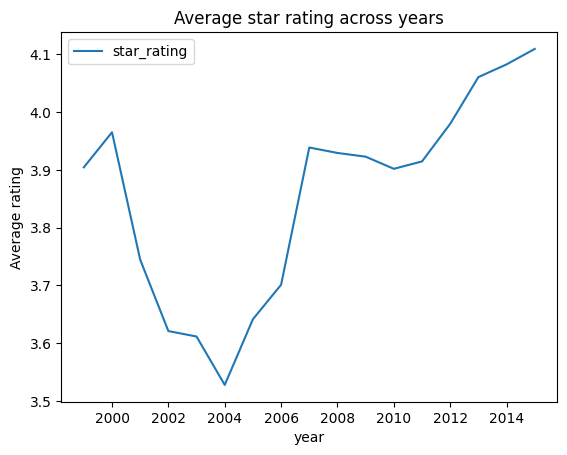

In [9]:
scores.plot(kind="line", title= "Average star rating across years",
           ylabel = "Average rating")


### Description 2:

By examining plot 2, we can discern a U-shaped pattern in the relationship between the average star rating and the year. Notably, the lowest average star rating occurs in 2004. There was a slight decrease between 2007 and 2011, but the rating kept increasing after 2011. This observation holds significance as it suggests the possibility of a change or disruption that subsequently led to a rebound in the average rating starting from 2004. Additionally, there is a possibility that the number of inauthentic reviewers has experienced an increase since that period. 

## Plot 3: What is the distribution of reviews by marketplace?

<Axes: title={'center': 'Number of reviews by marketplace'}, xlabel='marketplace', ylabel='No. of reviews'>

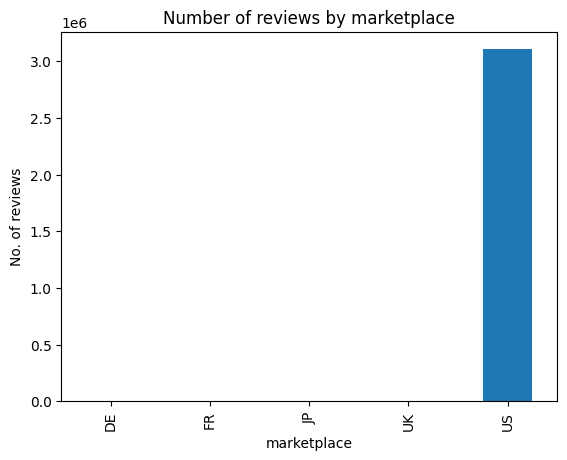

In [21]:
reviews_by_mp = (df[['marketplace','year']].groupby('marketplace').count())
reviews_df = reviews_by_mp.compute()
reviews_df.plot(kind="bar", title= "Number of reviews by marketplace",
           ylabel = "No. of reviews",legend=None)

In [23]:
reviews_df.head()

,year
marketplace,
DE,4035
FR,2363
JP,3361
UK,5851
US,3105328


### Description 3:

Upon analyzing plot 3, it becomes evident that the overwhelming majority of reviews were contributed by customers from the United States. Consequently, focusing solely on English reviews would suffice for scrutinizing the genuineness of the reviews.

## Plot 4: What is the distribution of reviews by verified purchase?

<Axes: title={'center': 'Number of reviews by verified purchase'}, xlabel='verified_purchase', ylabel='No. of reviews'>

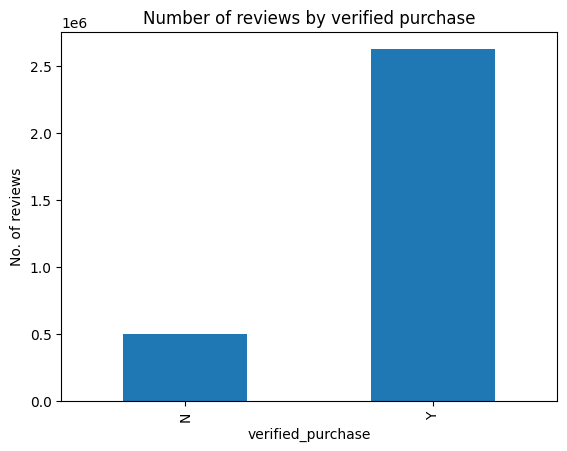

In [25]:
reviews_by_vp = (df[['verified_purchase','year']].groupby('verified_purchase').count())
reviews_df = reviews_by_vp.compute()
reviews_df.plot(kind="bar", title= "Number of reviews by verified purchase",
           ylabel = "No. of reviews",legend=None)

In [26]:
reviews_df.head()

,year
verified_purchase,
N,498022
Y,2622916


### Description 4:

The presence of a verified purchase can serve as a robust indicator of review authenticity, as it helps identify instances where bots or insincere reviewers express biased or malicious opinions without actually purchasing or using the products. As depicted in plot 4, a considerable portion of the reviews consisted of verified purchases.


## Plot 5: What is the distribution of reviews by vine?

<Axes: title={'center': 'Number of reviews by vine program'}, xlabel='vine', ylabel='No. of reviews'>

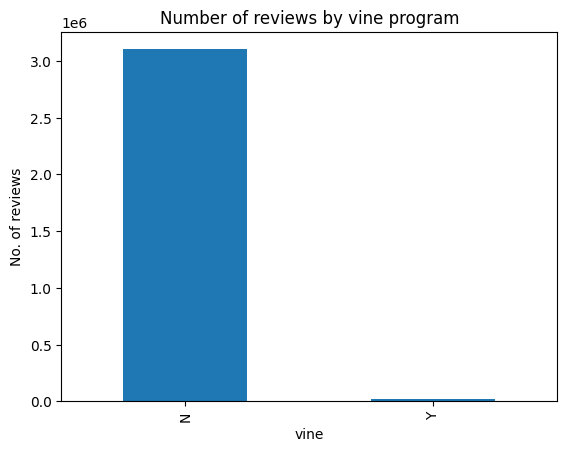

In [27]:
reviews_by_vine = (df[['vine','year']].groupby('vine').count())
reviews_df = reviews_by_vine.compute()
reviews_df.plot(kind="bar", title= "Number of reviews by vine program",
           ylabel = "No. of reviews",legend=None)

In [28]:
reviews_df.head()

,year
vine,
N,3101985
Y,18953


### Description 5:

The exclusive membership in the vine program is granted solely to customers who consistently deliver valuable and perceptive reviews. However, as depicted in plot 5, the majority of reviewers did not possess vine program membership.
